In [88]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
random_state = 42

## Introduction to the Problem

In the high-stakes world of battle royale games like PlayerUnknown's Battlegrounds (PUBG), every match is a new story. While winning is the ultimate goal, a player's experience is defined by more than just their final rank. A player who gets ten kills but is eliminated early due to bad luck has a vastly different—and likely more frustrating—experience than a player who hides and survives to the end with zero kills.

This project tackles that nuanced problem. Instead of predicting long-term churn, we aim to identify **in-match frustration**.

**The central question is: Can we use a player's in-match actions (kills, damage, distance traveled) to predict their expected final placement, and then use the *error* in that prediction to quantify how frustrating their match was?**

By answering this, we can create a "Frustration Score" to identify players who are performing well but not being rewarded. This could be used by game developers to fine-tune game balance or even by players themselves to understand their own performance beyond the final scoreboard.

## The Dataset

To answer our question, we are using data from the **PUBG Finish Placement Prediction** competition on Kaggle. This dataset contains detailed statistics from over 4 million individual player performances in PUBG matches.

Link to project: [PUBG Finish Placement Prediction](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

*To run this notebook, please download the `train_V2.csv` file from the link above and place it in the root directory of this project.*

*Note: The data file is not included in this repository due to its large size and to respect the data source's distribution policy.*

**Target Variable** Our primary goal is to predict a player's final placement. Therefore, our target variable ($y$) is:
* **`winPlacePerc`**: A continuous value from **0.0** (finished last) to **1.0** (won the match). It represents the player's rank as a percentile, providing a standardized measure of success across matches with different numbers of players.

**Features** 
From the many columns available, we will select a core set of features that best represent a player's skill, effort, and strategy during a match.

| Feature Name | Description | Data Type | Type |
| :--- | :--- | :--- | :--- |
| **`kills`** | Number of enemy players killed. | Numerical | Original |
| **`assists`** | Number of times a player assisted a teammate in a kill. | Numerical | Original |
| **`DBNOs`** | Number of times a player knocked down an enemy ("Down But Not Out"). | Numerical | Original |
| **`damageDealt`** | Total damage inflicted on opponents. | Numerical | Original |
| **`headshotKills`** | Number of kills that were headshots. | Numerical | Original |
| **`killStreaks`** | The player's longest kill streak in the match. | Numerical | Original |
| **`longestKill`** | The distance of the player's longest kill. | Numerical | Original |
| **`walkDistance`** | Total distance traveled on foot. | Numerical | Original |
| **`rideDistance`** | Total distance traveled in a vehicle. | Numerical | Original |
| **`swimDistance`** | Total distance traveled by swimming. | Numerical | Original |
| **`revives`** | Number of times a player revived a teammate. | Numerical | Original |
| **`heals`** | Number of healing items used. | Numerical | Original |
| **`boosts`** | Number of boosting items used. | Numerical | Original |
| **`weaponsAcquired`** | Number of weapons picked up. | Numerical | Original |
| **`teamKills`** | Number of times a player killed a teammate. | Numerical | Original |
| **`matchType`** | The type of match (e.g., 'squad-fpp', 'duo', 'solo'). | Categorical | Original |
| **`totalDistance`** | The sum of all travel distances (walk, ride, swim). | Numerical | Engineered |
| **`headshotRate`** | The percentage of a player's kills that were headshots. | Numerical | Engineered |
| **`itemsUsed`** | The combined total of healing and boosting items used. | Numerical | Engineered |
| **`Id`, `groupId`, `matchId`** | Unique identifiers for player, group, and match. | Categorical | Original |
| **`killPlace`** | Player's in-match rank based on number of kills. | Numerical | Original |
| **`killPoints`, `rankPoints`, `winPoints`** | Deprecated ranking points from the game's old system. | Numerical | Original |

## Data Loading and Initial Overview

In [56]:
# IMPORTANT NOTE: Our dataset contains more that 4 million rows
# so it may take a while to load it
# to speed loading times, analysts may consider using a sample of the dataset only
df = pd.read_csv('train_V2.csv')

In [57]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [58]:
print("Rows: ", df.shape[0], "\nColumns: ", df.shape[1])

Rows:  4446966 
Columns:  29


In [59]:
df.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.000000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,84.2400,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,47.0000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.000000,20.0


In [61]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

## Exploratory Data Analysis (EDA)

Let us start by observing the relationships of our features with each other and the target. That will help us get an early understanding of the behavior of our data. 

In [62]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df[num_cols].corr()
corr_with_target = corr['winPlacePerc'].drop('winPlacePerc').sort_values(key=abs, ascending=False)

### Distribution Analysis (Univariate)

<Figure size 1800x1000 with 0 Axes>

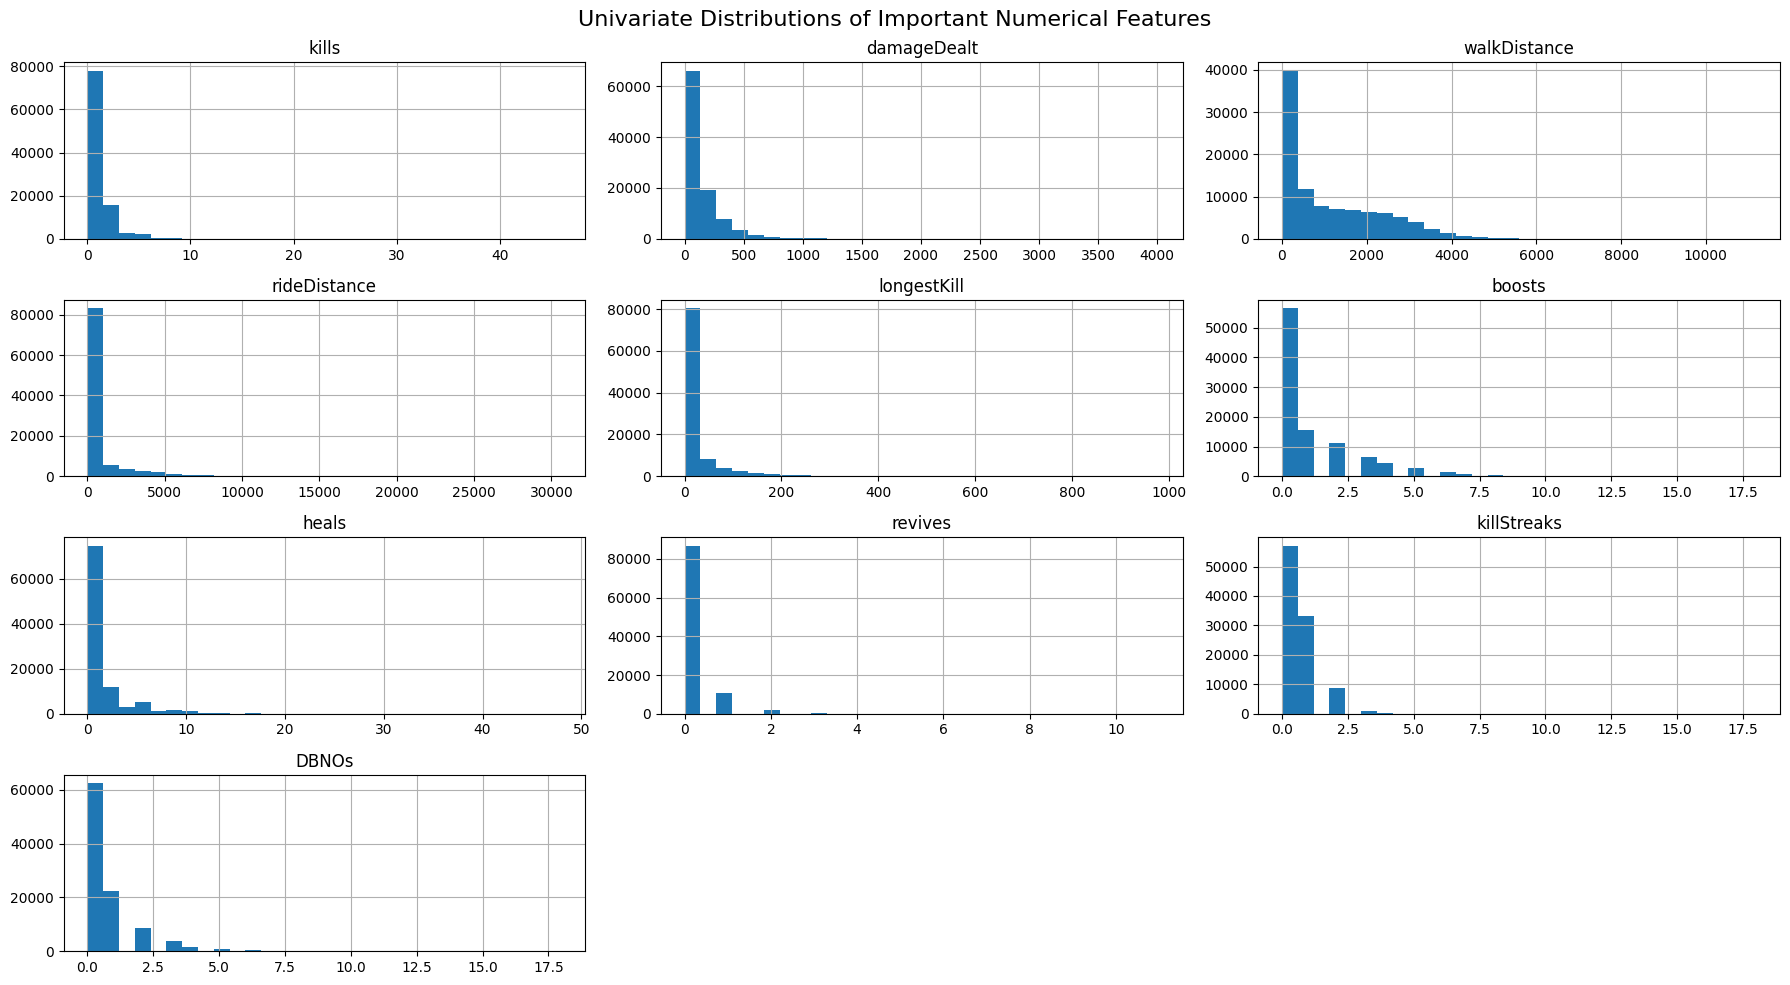

In [63]:
important_cols = ['kills','damageDealt','walkDistance','rideDistance','longestKill',
                  'boosts','heals','revives','killStreaks','DBNOs']
plt.figure(figsize=(18,10))
df.sample(100000, random_state=random_state)[important_cols].hist(figsize=(18,10), bins=30)
plt.suptitle('Univariate Distributions of Important Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

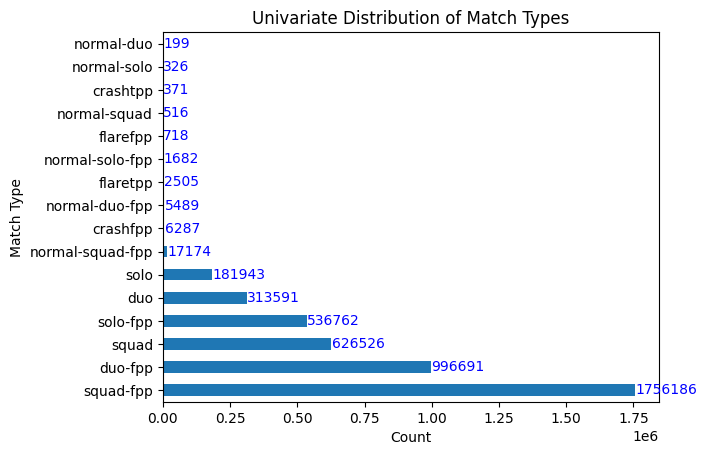

In [64]:
df['matchType'].value_counts().plot(kind='barh')
for i, v in enumerate(df['matchType'].value_counts()):
    plt.text(v + 1000, i, str(v), color='blue', va='center')
plt.xlabel('Count')
plt.ylabel('Match Type')
plt.title('Univariate Distribution of Match Types')
plt.show()

### Distribution Analysis (Bivariate)

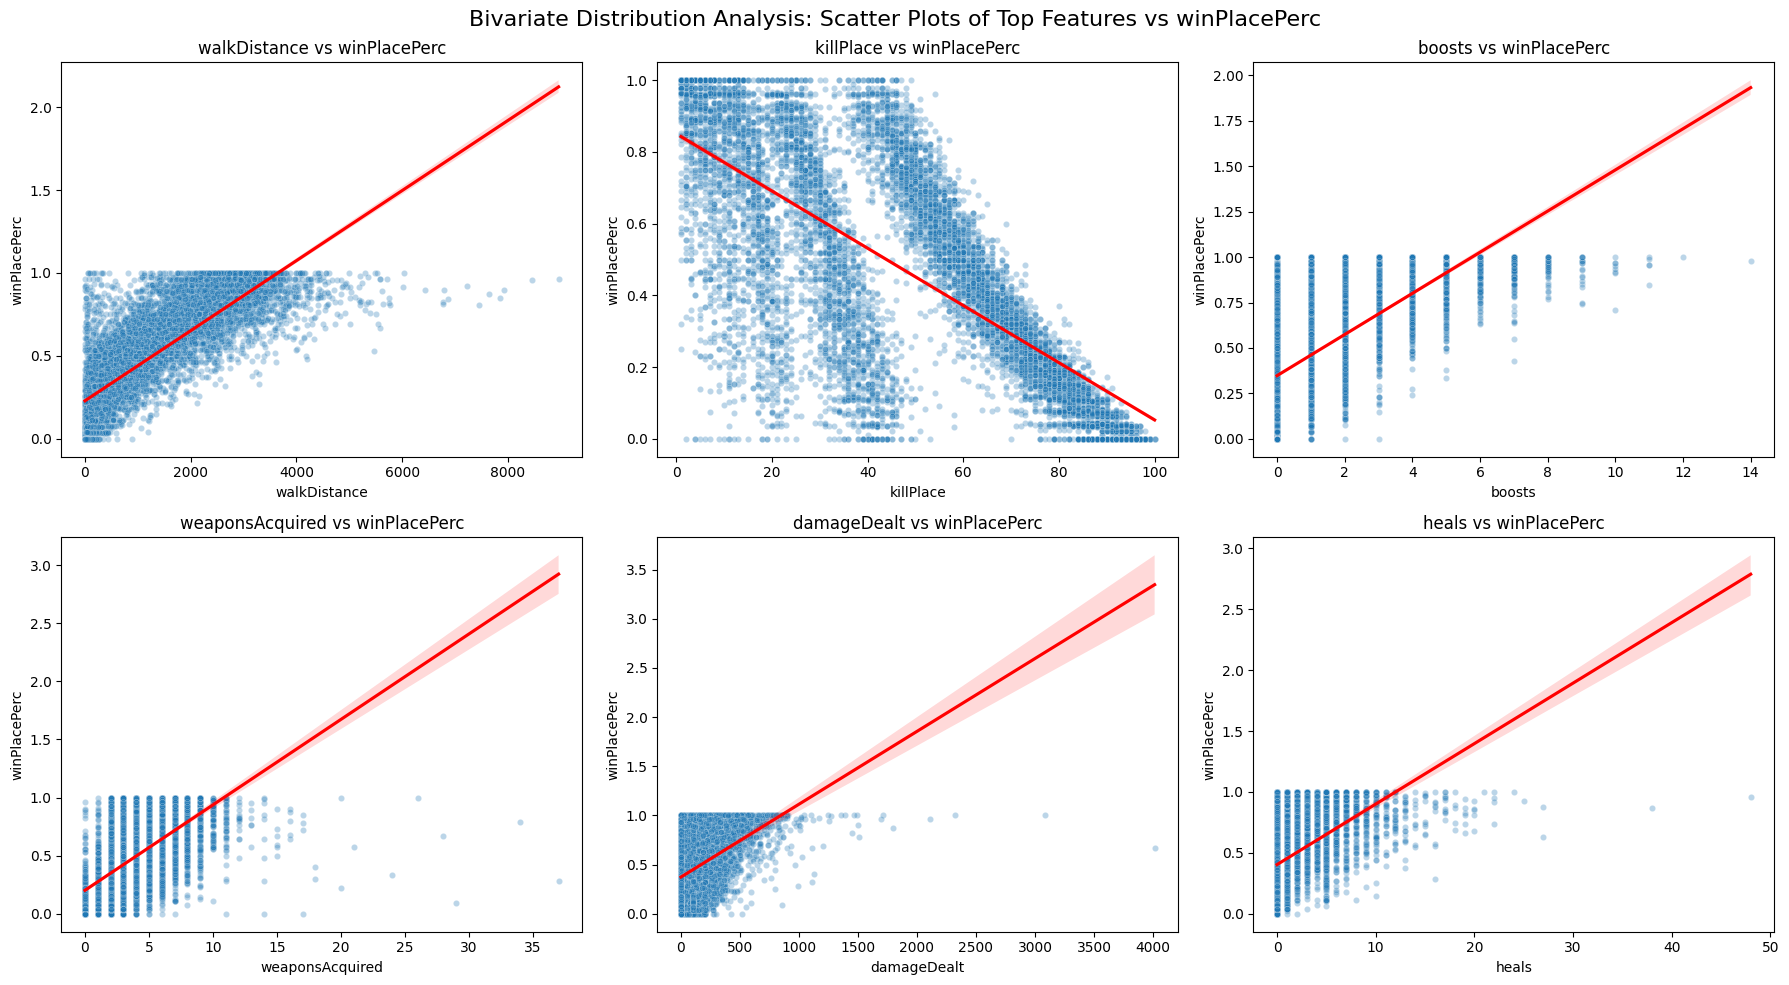

In [65]:
top_features = corr_with_target.head(6).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, feature in zip(axes.flatten(), top_features):
    sns.scatterplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        alpha=0.3, s=20, ax=ax
    )
    sns.regplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        scatter=False, color='red', ax=ax
    )
    ax.set_title(f'{feature} vs winPlacePerc')
plt.suptitle('Bivariate Distribution Analysis: Scatter Plots of Top Features vs winPlacePerc', fontsize=16)
plt.tight_layout()
plt.show()


### Target Variable Exploration

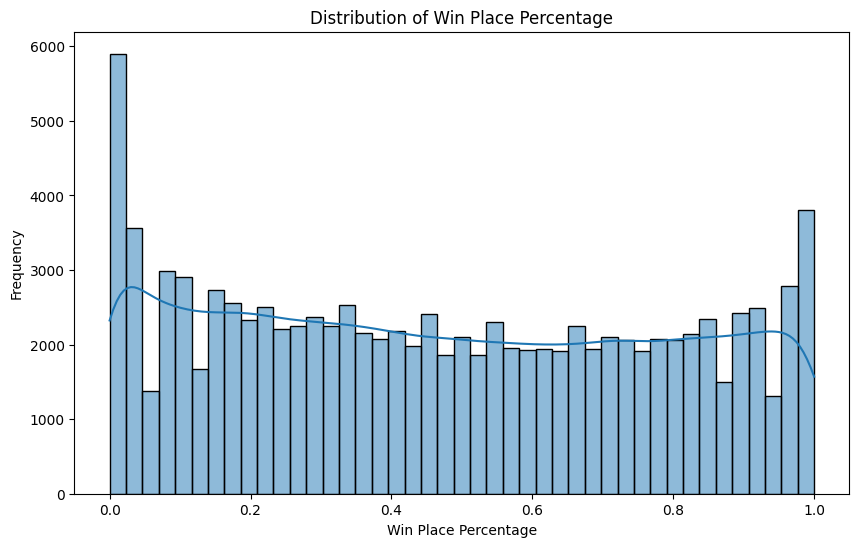

In [66]:
# use sample of 100K for histogram
plt.figure(figsize=(10, 6))
sns.histplot(df.sample(100000, random_state=random_state)['winPlacePerc'], kde=True)
plt.title('Distribution of Win Place Percentage')
plt.xlabel('Win Place Percentage')
plt.ylabel('Frequency')
plt.show()

### Outlier and Data Quality Check

C:\Users\dgane\AppData\Local\Temp\ipykernel_8640\2047475861.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_8640\2047475861.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_8640\2047475861.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dgane\AppData\Local\Temp\ipykernel_8640\2047475861.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=

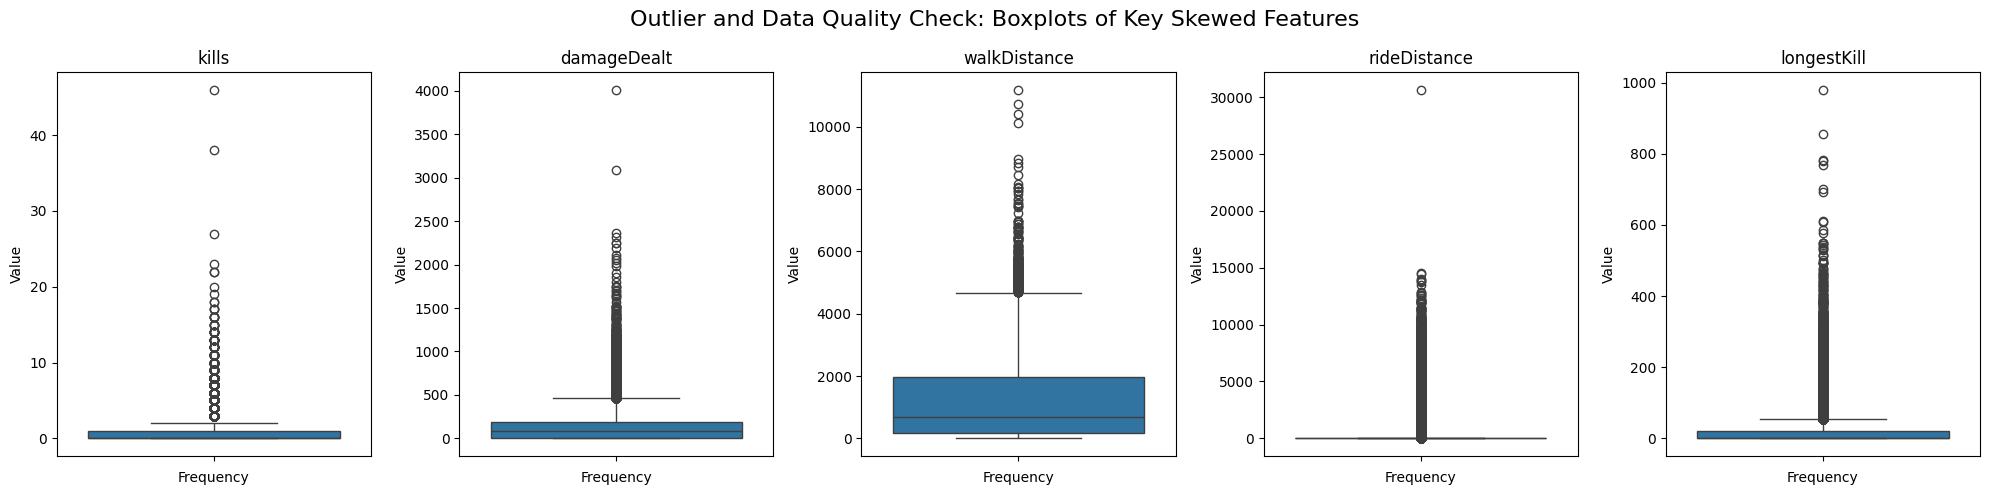

In [67]:
df[num_cols].max().sort_values(ascending=False).head(10)
df[num_cols].min().sort_values().head(10)

# Boxplots for key skewed features
key_features = ['kills', 'damageDealt', 'walkDistance', 'rideDistance', 'longestKill']

fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
for ax, feature in zip(axes, key_features):
    sns.boxplot(data=df.sample(50000, random_state=random_state), y=feature, ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('Value')
    ax.set_xlabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.suptitle('Outlier and Data Quality Check: Boxplots of Key Skewed Features', fontsize=16)
plt.tight_layout()
plt.show()


c:\Users\dgane\miniconda3\envs\itcs-3162\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


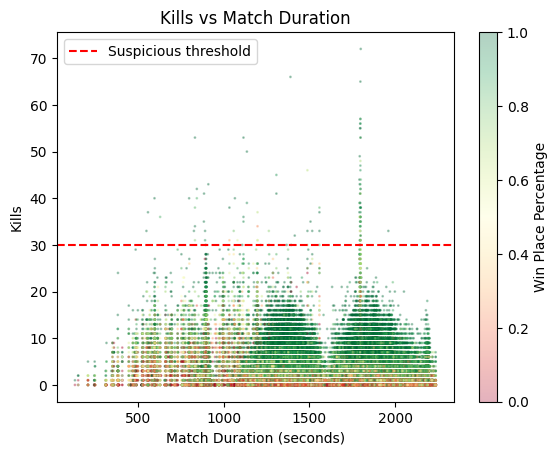

In [ ]:
plt.scatter(df['matchDuration'], df['kills'], 
                c=df['winPlacePerc'], cmap='RdYlGn', 
                alpha=0.3, s=1)
plt.axhline(y=30, color='r', linestyle='--', label='Suspicious threshold')
plt.xlabel('Match Duration (seconds)')
plt.ylabel('Kills')
plt.title('Kills vs Match Duration')
plt.legend()
plt.colorbar(label='Win Place Percentage')
plt.show()

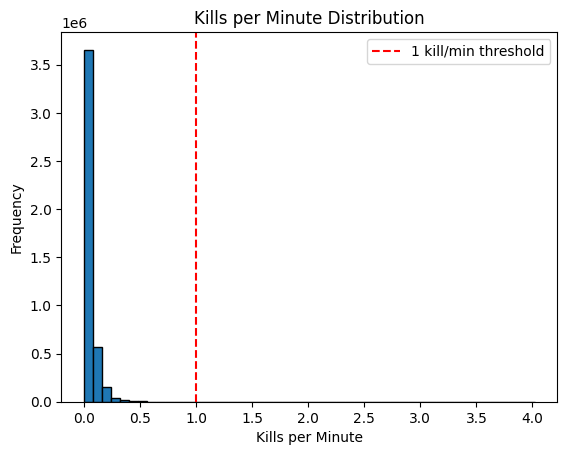

In [77]:
kills_per_minute = df['kills'] / (df['matchDuration'] / 60)
extreme_killers = df[df['kills'] > 30].copy()

plt.hist(kills_per_minute, bins=50, edgecolor='black')
plt.axvline(x=1.0, color='r', linestyle='--', label='1 kill/min threshold')
plt.xlabel('Kills per Minute')
plt.ylabel('Frequency')
plt.title('Kills per Minute Distribution')
plt.legend()
extreme_killers_display = extreme_killers[['Id', 'kills', 'matchDuration', 'winPlacePerc']]
extreme_killers_display.reset_index(drop=True, inplace=True)
plt.show()

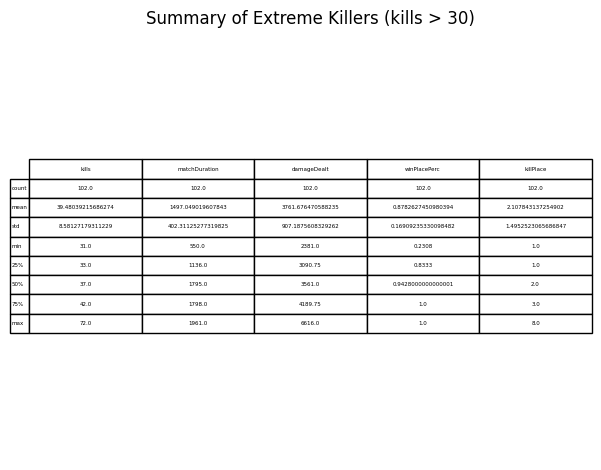

In [70]:
plt.axis('tight')
plt.axis('off')
summary_table = extreme_killers[['kills', 'matchDuration', 'damageDealt', 
                                   'winPlacePerc', 'killPlace']].describe()
table = plt.table(cellText=summary_table.values,
                      rowLabels=summary_table.index,
                      colLabels=summary_table.columns,
                      cellLoc='center',
                      loc='center')
plt.title('Summary of Extreme Killers (kills > 30)')

plt.tight_layout()
plt.show()

In [80]:
df['is_suspicious'] = (kills_per_minute > 1.5) | (df['kills'] > 40)
print(f"Suspicious records: {df['is_suspicious'].sum()} ({df['is_suspicious'].mean()*100}%)")

Suspicious records: 212 (0.004767295275025714%)


### Multicollinearity Heatmap

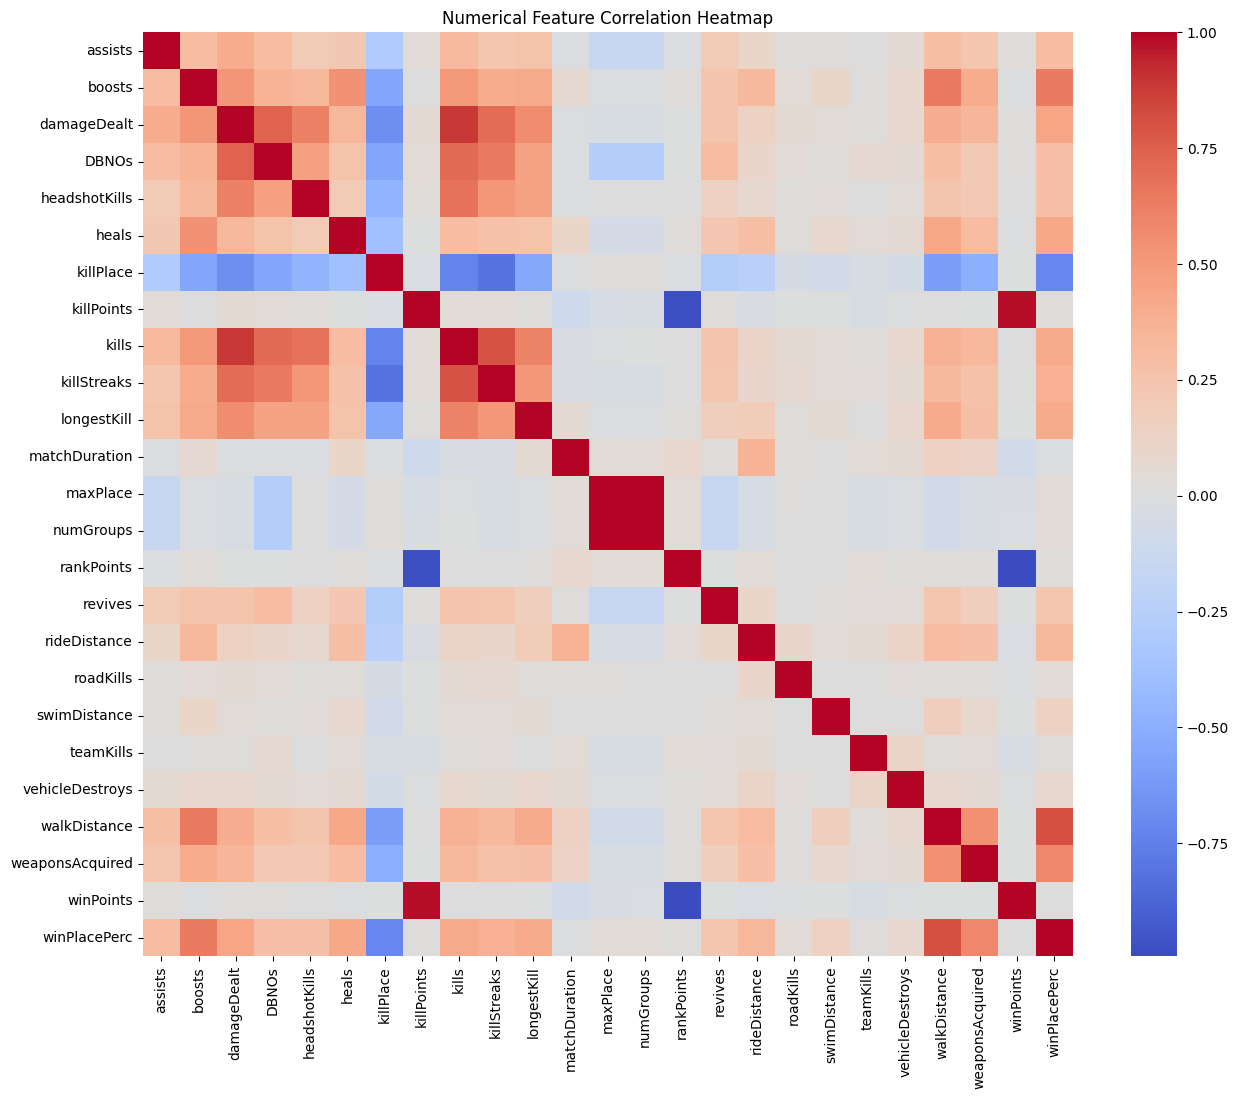

In [72]:
plt.figure(figsize=(15,12))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Numerical Feature Correlation Heatmap')
plt.show()

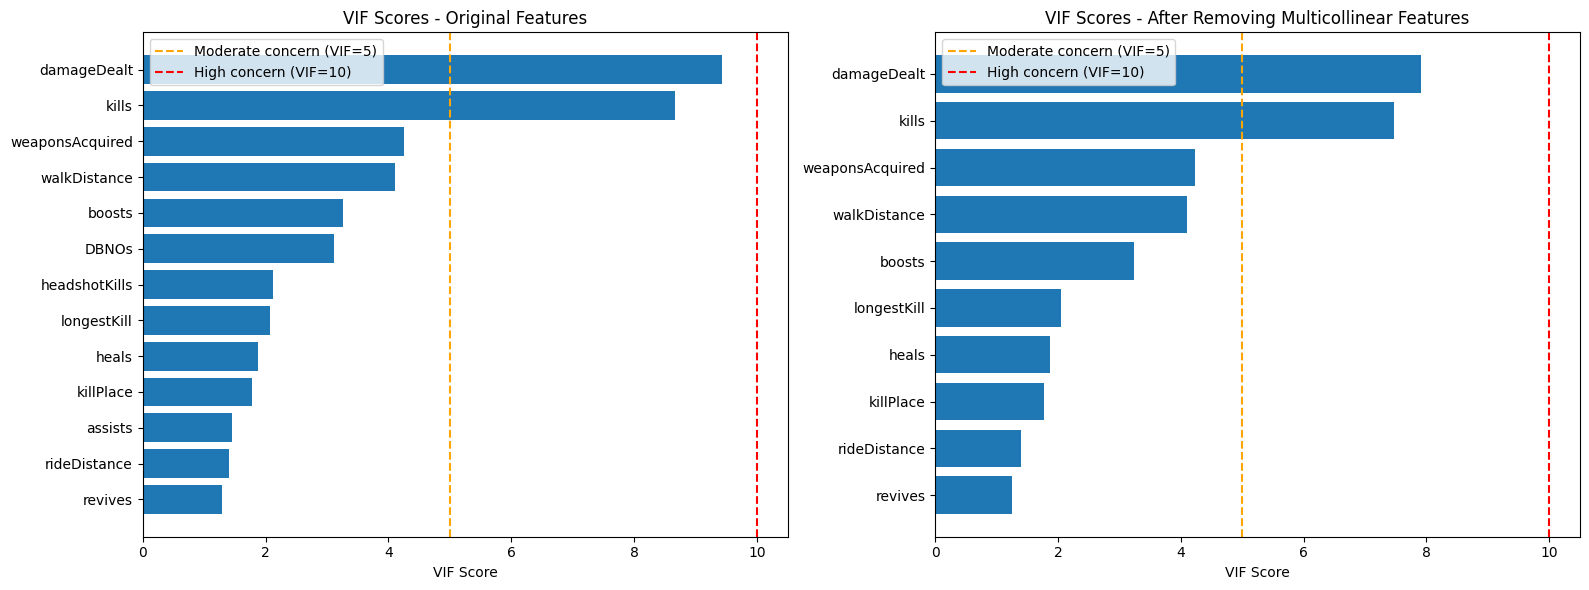


=== VIF COMPARISON ===

Original Features:
        Feature      VIF
    damageDealt 9.426776
          kills 8.672183
weaponsAcquired 4.262958
   walkDistance 4.109643
         boosts 3.257303
          DBNOs 3.112413
  headshotKills 2.115166
    longestKill 2.065292
          heals 1.877476
      killPlace 1.776821
        assists 1.460447
   rideDistance 1.402036
        revives 1.299006

Features with VIF > 10: 0
Features with VIF > 5: 2


Cleaned Features:
        Feature      VIF
    damageDealt 7.904491
          kills 7.465115
weaponsAcquired 4.237975
   walkDistance 4.095866
         boosts 3.229172
    longestKill 2.049880
          heals 1.873519
      killPlace 1.771917
   rideDistance 1.401145
        revives 1.251594

Features with VIF > 10: 0
Features with VIF > 5: 2

=== RECOMMENDATIONS ===
✅ All VIF scores < 10. Multicollinearity resolved!


In [ ]:
# Define feature sets
features_original = ['kills', 'assists', 'boosts', 'damageDealt', 'DBNOs', 
                     'headshotKills', 'heals', 'killPlace', 'longestKill',
                     'revives', 'rideDistance', 'walkDistance', 'weaponsAcquired']

features_cleaned = ['kills', 'boosts', 'damageDealt', 'heals', 'killPlace', 
                   'longestKill', 'revives', 'rideDistance', 'walkDistance', 
                   'weaponsAcquired']  # Dropped: assists, DBNOs, headshotKills

def calculate_vif(data, features):
    """Calculate VIF for given features"""
    X = data[features].fillna(0)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF for both sets
vif_original = calculate_vif(df, features_original)
vif_cleaned = calculate_vif(df, features_cleaned)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Original features
axes[0].barh(vif_original['Feature'], vif_original['VIF'])
axes[0].axvline(x=5, color='orange', linestyle='--', label='Moderate concern (VIF=5)')
axes[0].axvline(x=10, color='r', linestyle='--', label='High concern (VIF=10)')
axes[0].set_xlabel('VIF Score')
axes[0].set_title('VIF Scores - Original Features')
axes[0].legend()
axes[0].invert_yaxis()

# Plot B: Cleaned features
axes[1].barh(vif_cleaned['Feature'], vif_cleaned['VIF'])
axes[1].axvline(x=5, color='orange', linestyle='--', label='Moderate concern (VIF=5)')
axes[1].axvline(x=10, color='r', linestyle='--', label='High concern (VIF=10)')
axes[1].set_xlabel('VIF Score')
axes[1].set_title('VIF Scores - After Removing Multicollinear Features')
axes[1].legend()
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary
print("\n=== VIF COMPARISON ===")
print("\nOriginal Features:")
print(vif_original.to_string(index=False))
print(f"\nFeatures with VIF > 10: {(vif_original['VIF'] > 10).sum()}")
print(f"Features with VIF > 5: {(vif_original['VIF'] > 5).sum()}")

print("\n" + "="*50)
print("\nCleaned Features:")
print(vif_cleaned.to_string(index=False))
print(f"\nFeatures with VIF > 10: {(vif_cleaned['VIF'] > 10).sum()}")
print(f"Features with VIF > 5: {(vif_cleaned['VIF'] > 5).sum()}")

# Decision rules
print("\n=== RECOMMENDATIONS ===")
problem_features = vif_cleaned[vif_cleaned['VIF'] > 10]['Feature'].tolist()
if problem_features:
    print(f"⚠️ Still problematic: {problem_features}")
    print("Consider dropping or combining these features")
else:
    print("✅ All VIF scores < 10. Multicollinearity resolved!")

### Match-Type Stratification

C:\Users\dgane\AppData\Local\Temp\ipykernel_8640\3539329293.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 1000), random_state=random_state)) #suppress warning


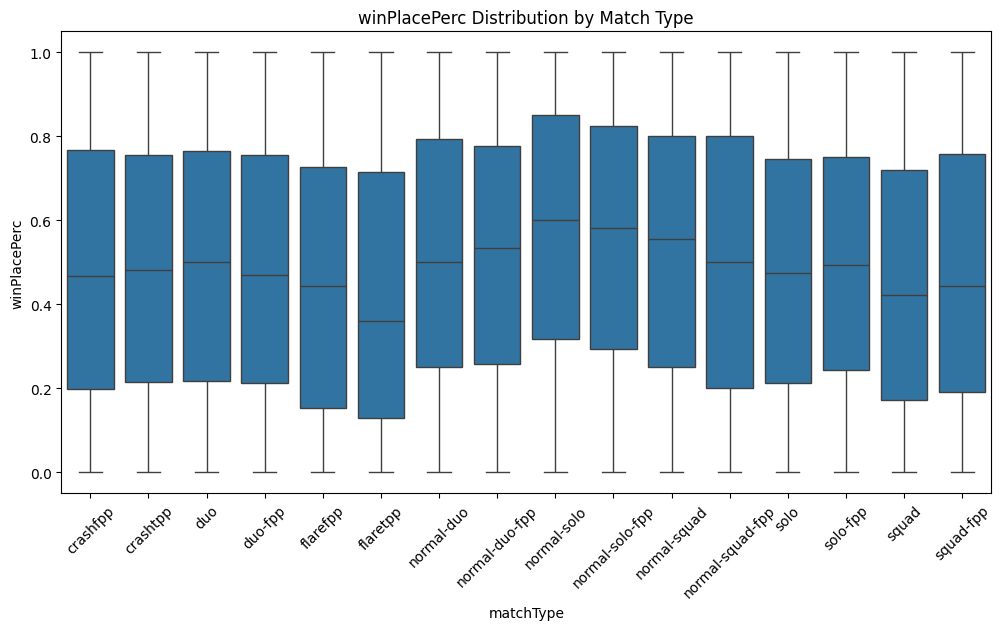

In [73]:
df_sample = (
    df.groupby('matchType', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), 1000), random_state=random_state)) #suppress warning
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sample, x='matchType', y='winPlacePerc', )
plt.xticks(rotation=45)
plt.title('winPlacePerc Distribution by Match Type')
plt.show()


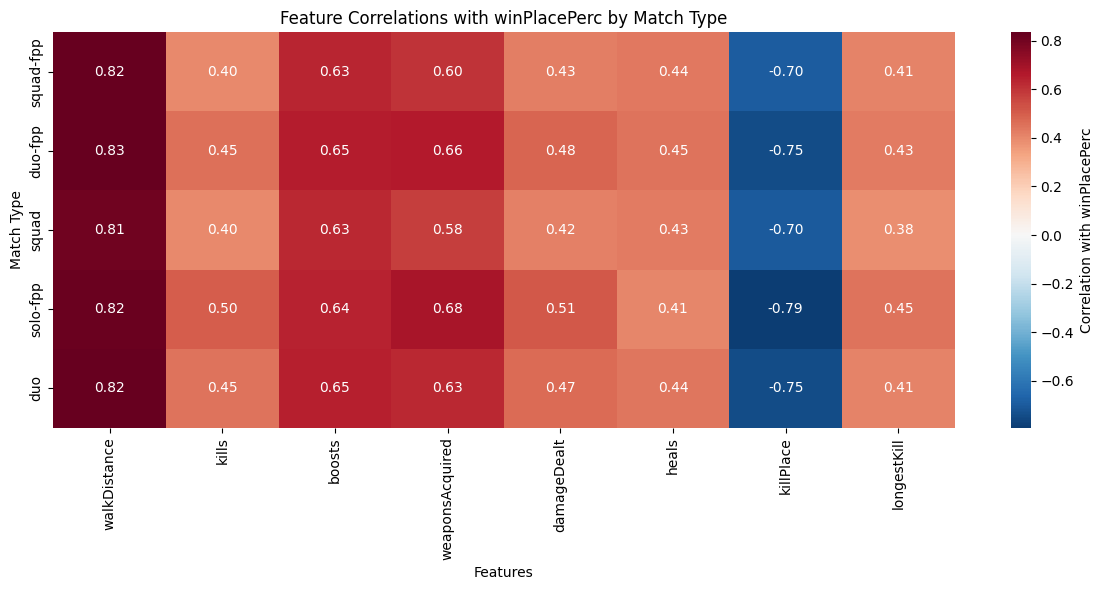

In [84]:
top_match_types = df['matchType'].value_counts().head(5).index
correlation_by_match = {}
features_to_check = ['walkDistance', 'kills', 'boosts', 'weaponsAcquired', 
                     'damageDealt', 'heals', 'killPlace', 'longestKill']

for match_type in top_match_types:
    match_data = df[df['matchType'] == match_type]
    correlations = match_data[features_to_check + ['winPlacePerc']].corr()['winPlacePerc'].drop('winPlacePerc')
    correlation_by_match[match_type] = correlations

corr_df = pd.DataFrame(correlation_by_match).T

plt.figure(figsize=(12, 6))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation with winPlacePerc'})
plt.title('Feature Correlations with winPlacePerc by Match Type')
plt.xlabel('Features')
plt.ylabel('Match Type')
plt.tight_layout()
plt.show()


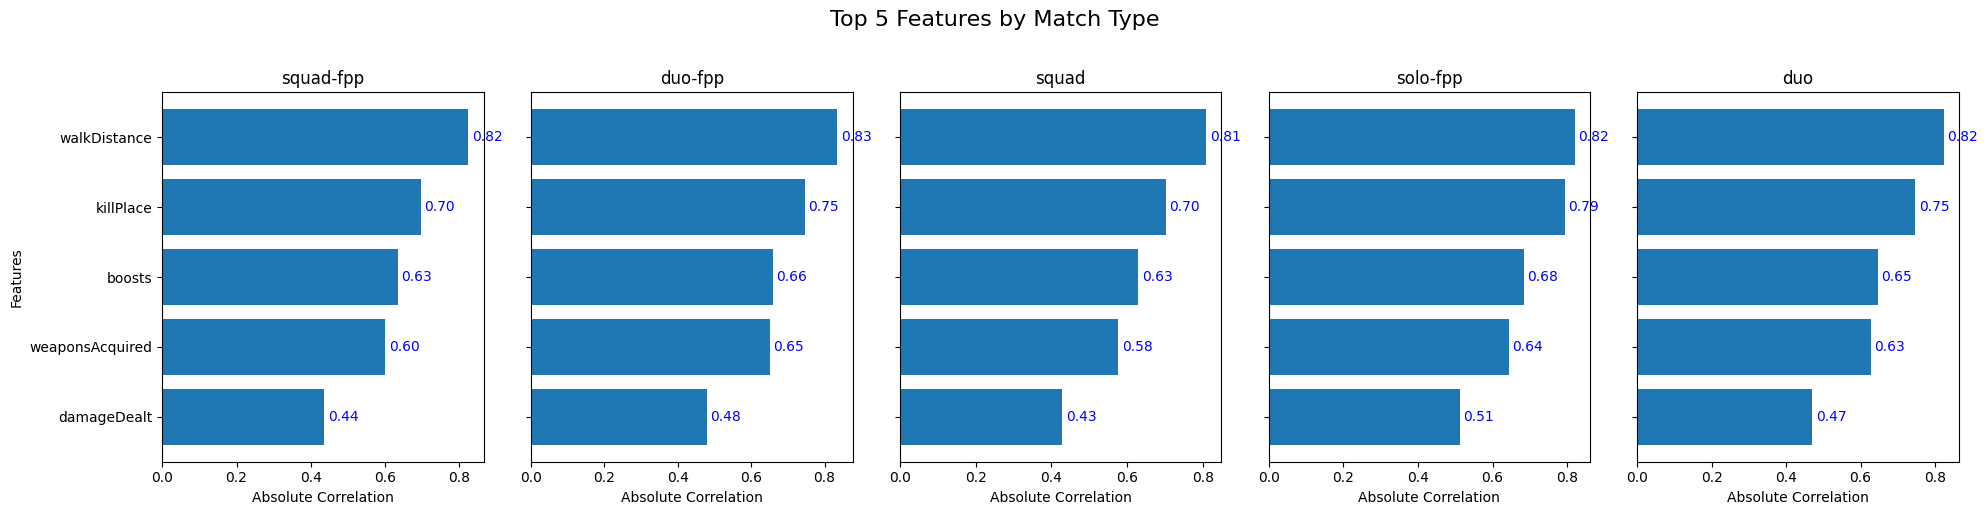

In [86]:
fig, axes = plt.subplots(1, len(top_match_types), figsize=(20, 5), sharey=True)
for idx, match_type in enumerate(top_match_types):
    top_features = corr_df.loc[match_type].abs().sort_values(ascending=False).head(5)
    axes[idx].barh(range(len(top_features)), top_features.values)
    for i, v in enumerate(top_features.values):
        axes[idx].text(v + 0.01, i, f"{v:.2f}", color='blue', va='center')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features.index)
    axes[idx].set_xlabel('Absolute Correlation')
    axes[idx].set_title(f'{match_type}')
    axes[idx].invert_yaxis()

axes[0].set_ylabel('Features')
plt.suptitle('Top 5 Features by Match Type', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [87]:
print("\n=== Correlation Comparison Across Match Types ===")
for feature in features_to_check:
    print(f"\n{feature}:")
    print(corr_df[feature].sort_values(ascending=False))


=== Correlation Comparison Across Match Types ===

walkDistance:
duo-fpp      0.834562
squad-fpp    0.824479
duo          0.823122
solo-fpp     0.820297
squad        0.807673
Name: walkDistance, dtype: float64

kills:
solo-fpp     0.501450
duo-fpp      0.453257
duo          0.447561
squad-fpp    0.401384
squad        0.400332
Name: kills, dtype: float64

boosts:
duo-fpp      0.650331
duo          0.646184
solo-fpp     0.643547
squad-fpp    0.634155
squad        0.628680
Name: boosts, dtype: float64

weaponsAcquired:
solo-fpp     0.683014
duo-fpp      0.658328
duo          0.627273
squad-fpp    0.600584
squad        0.576692
Name: weaponsAcquired, dtype: float64

damageDealt:
solo-fpp     0.511793
duo-fpp      0.478546
duo          0.470270
squad-fpp    0.427035
squad        0.418764
Name: damageDealt, dtype: float64

heals:
duo-fpp      0.449574
duo          0.444117
squad-fpp    0.436548
squad        0.428035
solo-fpp     0.405270
Name: heals, dtype: float64

killPlace:
squad-fpp   -

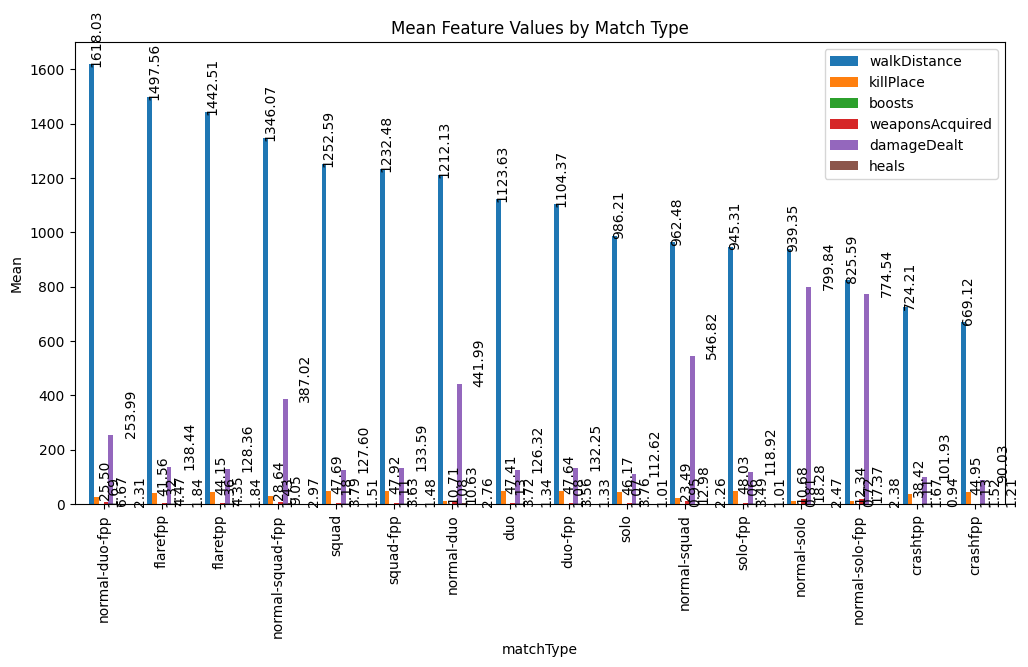

In [74]:
agg_cols = top_features.to_list()
match_summary = df.groupby('matchType')[agg_cols].mean().sort_values(by=agg_cols[0], ascending=False)
match_summary.plot(kind='bar', figsize=(12,6))
for i, col in enumerate(agg_cols):
    for j, v in enumerate(match_summary[col]):
        plt.text(j - 0.25 + i*0.15, v + 0.01, f"{v:.2f}", color='black', rotation=90)
plt.title('Mean Feature Values by Match Type')
plt.ylabel('Mean')
plt.show()

### Log-Transform Visualization

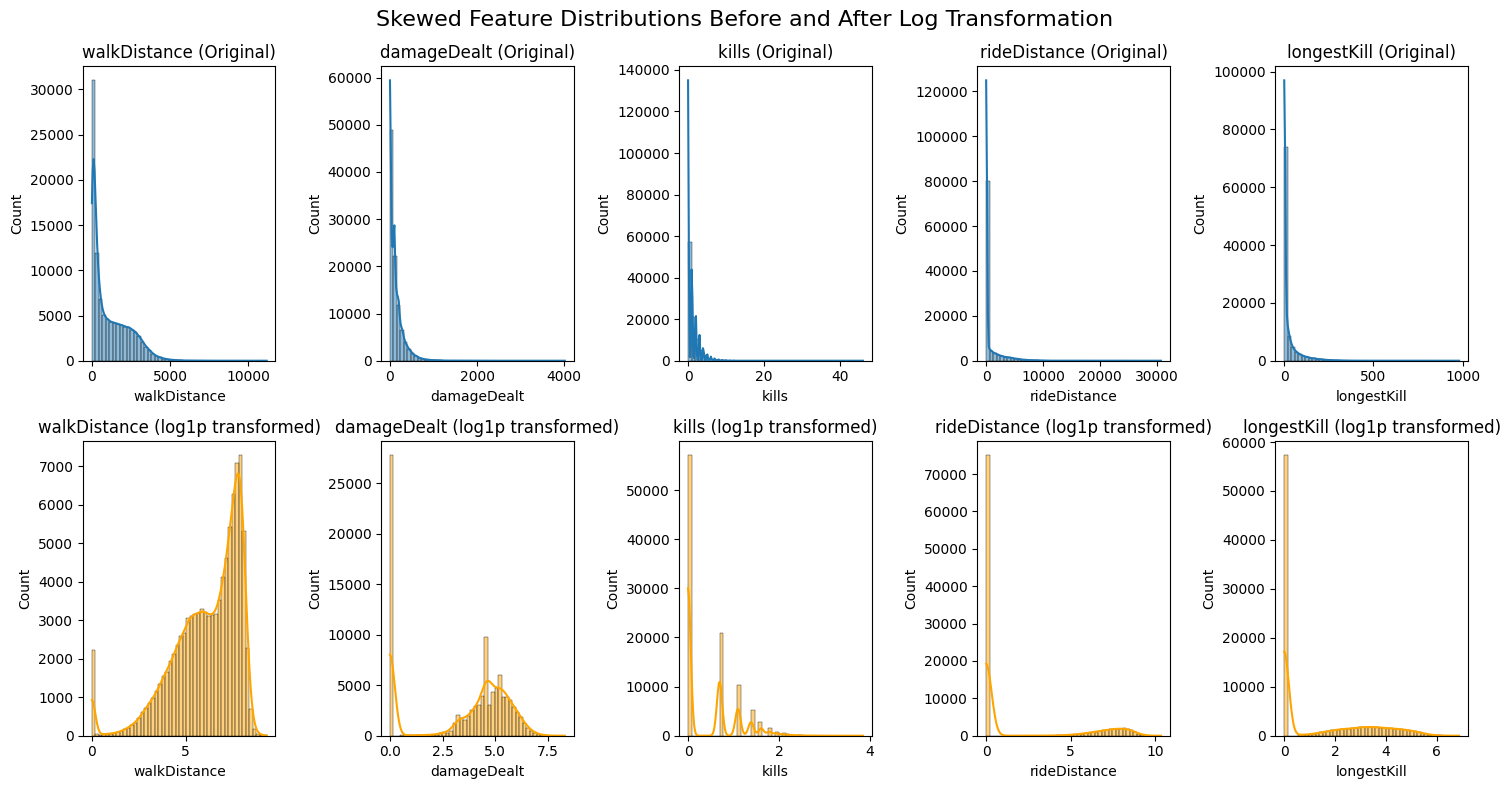

In [75]:
skewed_features = ['walkDistance', 'damageDealt', 'kills', 'rideDistance', 'longestKill']

fig, axes = plt.subplots(2, len(skewed_features), figsize=(15, 8))
for i, feature in enumerate(skewed_features):
    sns.histplot(df.sample(100000, random_state=random_state)[feature], bins=50, ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'{feature} (Original)')
    
    # Log transform safely (add small epsilon to avoid log(0))
    sns.histplot(np.log1p(df.sample(100000, random_state=random_state)[feature]), bins=50, ax=axes[1, i], kde=True, color='orange')
    axes[1, i].set_title(f'{feature} (log1p transformed)')
plt.suptitle('Skewed Feature Distributions Before and After Log Transformation', fontsize=16)
plt.tight_layout()
plt.show()

### Feature-Target Correlation

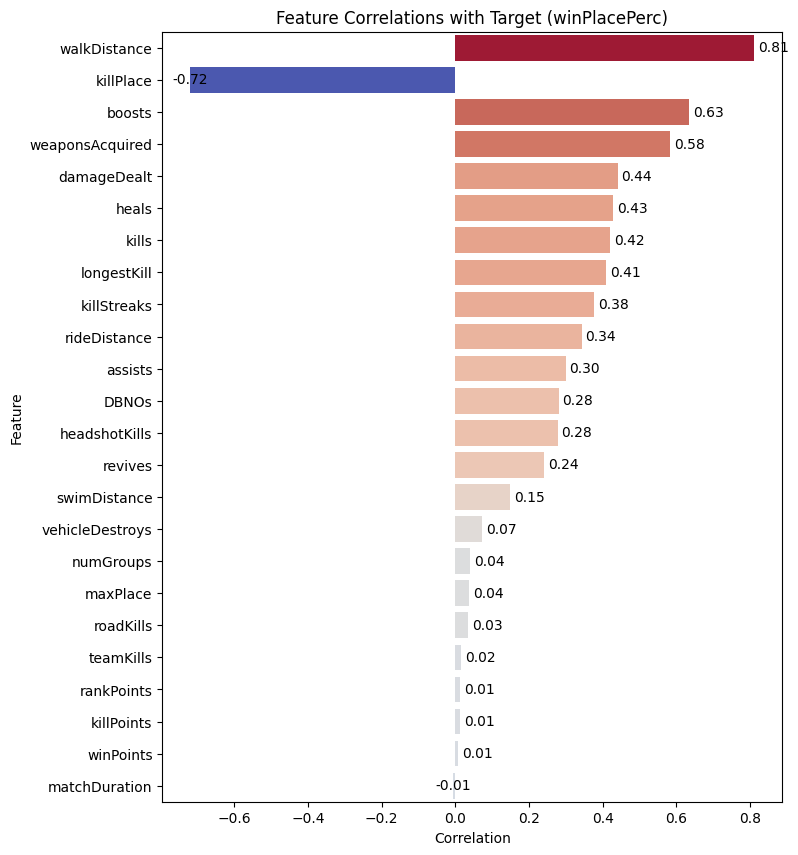

In [76]:
plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_with_target,
    y=corr_with_target.index,
    palette='coolwarm',
    hue=corr_with_target,
    legend=False
)
for i, v in enumerate(corr_with_target):
    plt.text(v + 0.01 if v > 0 else v - 0.05, i, f"{v:.2f}", color='black', va='center')
plt.title('Feature Correlations with Target (winPlacePerc)')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()
